In [69]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.1)

In [2]:
# miara jakości modeli

def _balanced_accuracy(y_true, y_pred):
    p = (y_true == 1).sum()
    n = (y_true == 1).sum()
    tp = ( (y_pred == 1) & (y_true == 1) ).sum()
    tn = ( (y_pred == -1) & (y_true == -1) ).sum()
    return (tp/p + tn/n) / 2

balanced_accuracy = make_scorer(_balanced_accuracy, greater_is_better=True)

In [3]:
# wczytanie danych

X_train = pd.read_csv("../../artificial_train.data", sep=" ", header=None).iloc[:, :500]
y_train = pd.read_csv("../../artificial_train.labels", sep=" ", header=None).iloc[:, 0]
X_test = pd.read_csv("../../artificial_test.data", sep=" ", header=None).iloc[:, :500]

## Ręcznie przygotowany model

### Szybkie spojrzenie na dane

In [4]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


In [5]:
# braki danych
X_train.isna().any().any()

False

In [6]:
X_test.isna().any().any()

False

In [7]:
# zmienna celu
y_train.value_counts()

-1    1000
 1    1000
Name: 0, dtype: int64

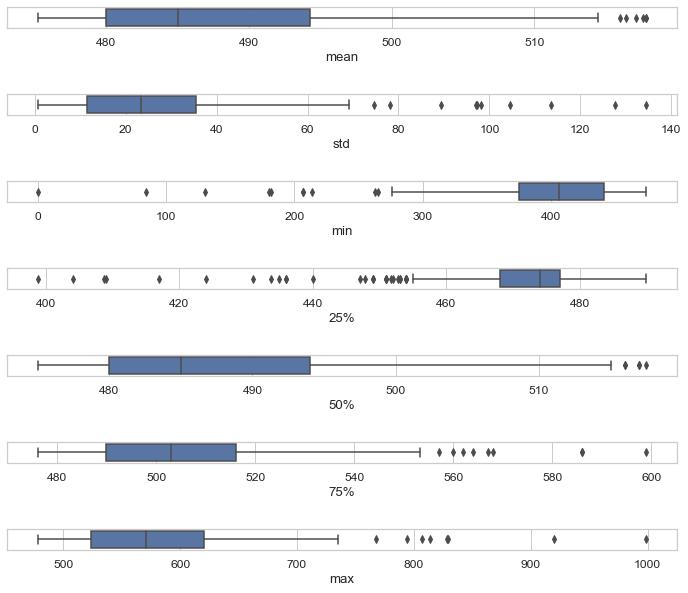

In [29]:
# rozkłady statystyk

# zmienne na pierwszy rzut oka wydają się pochodzić z podobnego rozkładu (średnia między 470 i 520)
# jednakże, różnią się między sobą wariancją
# niektóre zmienne przyjmują znacznie szerszy zakres wartości niż inne

describe_df = pd.concat([X_train[col].describe() for col in X_train], axis=1).T.drop(columns="count")

fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(12, 10))

sns.boxplot(data=describe_df, x="mean", ax=axs[0])
sns.boxplot(data=describe_df, x="std", ax=axs[1])
sns.boxplot(data=describe_df, x="min", ax=axs[2])
sns.boxplot(data=describe_df, x="25%", ax=axs[3])
sns.boxplot(data=describe_df, x="50%", ax=axs[4])
sns.boxplot(data=describe_df, x="75%", ax=axs[5])
sns.boxplot(data=describe_df, x="max", ax=axs[6])

plt.subplots_adjust(hspace=3)
# plt.suptitle("Rozkłady wartości wybranych statystyk obliczonych na treningowym zbiorze danych", y=0.93, fontsize=14)
plt.savefig("stats.png", dpi=300, bbox_inches="tight")
plt.show()

#### Potencjalne problemy:
* modelowi nie uda się wykryć istotnych zmiennych ze zbioru danych
* model zbyt mocno dopasuje się do danych treningowych i wynik na zbiorze testowym będzie słaby

#### Proponowane rozwiązania:
* próba ograniczenia zbioru zmiennych
* zastosowanie poczwórnej krosswalidacji (zbiór treningowy nie jest zbyt duży)

#### Plan działania:
* wytrenowanie modeli na pełnym zbiorze danych:
    * regresja LASSO (z mocną regularyzacją)
    * las losowy
    * xgboost
* powtórne zastosowanie modeli lasu losowego i xgboost na najbardziej istotnych zmiennych z regresji
* powtórne zastosowanie modeli regfresji, lasu losowego i xgboost na najbardziej istotnych (pod względem *feature importance*) z lasu losowego
* przekształcenie danych za pomocą PCA oraz zastosowanie modeli regresji, lasu losowego oraz xgboost na najbardziej znaczących czynnikach
* wybór modelu, który osiągnął najlepszy wynik

### Trenowanie modeli na pełnym zbiorze danych

#### regresja LASSO

In [9]:
lr_full =  GridSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('lr', LogisticRegression(penalty="l1", solver="liblinear", max_iter=100, random_state=0)),
        ]
    ),
    param_grid={
        "lr__C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
    },
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train, y=y_train)

lr_full.best_score_

0.615

#### las losowy

In [10]:
rf_full = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
        ]
    ),
    param_distributions={
        'rf__max_depth': [2, 6, 10, 16, 20],
        'rf__min_samples_split': [2, 4, 6, 10, 15, 20],
        'rf__min_samples_leaf': [2, 5, 10, 15, 20],
        'rf__max_features': [2, 4, 6, 10, "auto"],
        'rf__max_leaf_nodes': [25, 50, 75, 100],
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train, y=y_train)

rf_full.best_score_

0.647

#### xgboost

In [11]:
xgb_full = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('xgb', XGBClassifier(objective='binary:logistic', n_estimators=100, eval_metric='logloss', random_state=0)),
        ]
    ),
    param_distributions={
        'xgb__max_depth': range(2, 10, 2),
        'xgb__gamma': np.arange(0, 1.0, 0.2),
        'xgb__min_child_weight': range(2, 20, 3),
        'xgb__subsample': np.arange(0.2, 1.0, 0.2),
        'xgb__colsample_bytree': np.arange(0.2, 1.0, 0.2)
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train, y=y_train)

xgb_full.best_score_

0.768

### Trenowanie modeli na zbiorze istotnych zmiennych z regresji

In [12]:
# sprawdzamy współczynniki w modelu regresji
# co ciekawe, tylko dwie zmienne mają niezerowy współczynnik

coef = lr_full.best_estimator_.steps[1][1].coef_[0]
pd.Series(coef, name="coef").abs().sort_values(ascending=False).round(4).reset_index()

,index,coef
0,475,0.2415
1,48,0.0311
2,343,0.0000
3,341,0.0000
4,340,0.0000
...,...,...
495,162,0.0000
496,161,0.0000
497,160,0.0000
498,159,0.0000


#### las losowy

In [13]:
rf_lasso = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
        ]
    ),
    param_distributions={
        'rf__max_depth': [2, 6, 10, 16, 20],
        'rf__min_samples_split': [2, 4, 6, 10, 15, 20],
        'rf__min_samples_leaf': [2, 5, 10, 15, 20],
        'rf__max_features': [2, 4, 6, 10, "auto"],
        'rf__max_leaf_nodes': [25, 50, 75, 100],
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train.loc[:, [48, 475]], y=y_train)

rf_lasso.best_score_

0.6175

#### xgboost

In [14]:
xgb_lasso = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('xgb', XGBClassifier(objective='binary:logistic', n_estimators=100, eval_metric='logloss', random_state=0)),
        ]
    ),
    param_distributions={
        'xgb__max_depth': range(2, 10, 2),
        'xgb__gamma': np.arange(0, 1.0, 0.2),
        'xgb__min_child_weight': range(2, 20, 3),
        'xgb__subsample': np.arange(0.2, 1.0, 0.2),
        'xgb__colsample_bytree': np.arange(0.2, 1.0, 0.2)
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train.loc[:, [48, 475]], y=y_train)

xgb_lasso.best_score_

0.6050000000000001

### Trenowanie modeli na zbiorze zmiennych o wysokim *feature_importances_* z modelu lasu losowego

In [31]:
# sprawdzamy *feature_importances_* w modelu lasu losowego
# zmienna 475 jest 2. najważniejsza
# zmienna 48 jest 12. z kolei


feature_importances_ = rf_full.best_estimator_.steps[1][1].feature_importances_
feature_importances_ = pd.Series(feature_importances_, name="importance").abs().sort_values(ascending=False).round(4).reset_index()
feature_importances_

,index,importance
0,241,0.0168
1,475,0.0153
2,338,0.0144
3,105,0.0108
4,442,0.0104
...,...,...
495,280,0.0005
496,228,0.0004
497,90,0.0004
498,423,0.0002


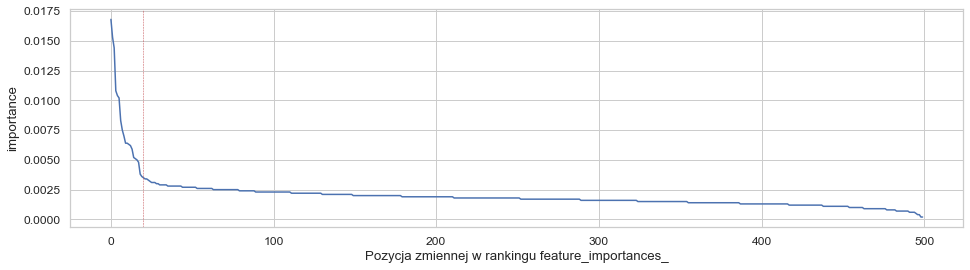

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

sns.lineplot(x=range(500), y=feature_importances_.importance)
plt.axvline(x=20, lw=0.5, c="r", ls="--")
plt.xlabel("Pozycja zmiennej w rankingu feature_importances_")
# plt.title("Wartości feature_importances_ z modelu lasu losowego posortowane malejąco", fontsize=14)
plt.savefig("feature_importances_.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
# wyraźny "łokieć" około 20. zmiennej
# wybieramy te zmienne do dalszej analizy

important_features = feature_importances_["index"].iloc[:20]

#### regresja LASSO

In [18]:
lr_fi =  GridSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('lr', LogisticRegression(penalty="l1", solver="liblinear", max_iter=100, random_state=0)),
        ]
    ),
    param_grid={
        "lr__C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
    },
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train.loc[:, important_features], y=y_train)

lr_fi.best_score_

0.615

#### las losowy

In [19]:
rf_fi = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
        ]
    ),
    param_distributions={
        'rf__max_depth': [2, 6, 10, 16, 20],
        'rf__min_samples_split': [2, 4, 6, 10, 15, 20],
        'rf__min_samples_leaf': [2, 5, 10, 15, 20],
        'rf__max_features': [2, 4, 6, 10, "auto"],
        'rf__max_leaf_nodes': [25, 50, 75, 100],
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train.loc[:, important_features], y=y_train)

rf_fi.best_score_

0.874

#### xgboost

In [20]:
xgb_fi = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('xgb', XGBClassifier(objective='binary:logistic', n_estimators=100, eval_metric='logloss', random_state=0)),
        ]
    ),
    param_distributions={
        'xgb__max_depth': range(2, 10, 2),
        'xgb__gamma': np.arange(0, 1.0, 0.2),
        'xgb__min_child_weight': range(2, 20, 3),
        'xgb__subsample': np.arange(0.2, 1.0, 0.2),
        'xgb__colsample_bytree': np.arange(0.2, 1.0, 0.2)
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train.loc[:, important_features], y=y_train)

xgb_fi.best_score_

0.8674999999999999

### Trenowanie modeli na zbiorze przekształconym przez PCA

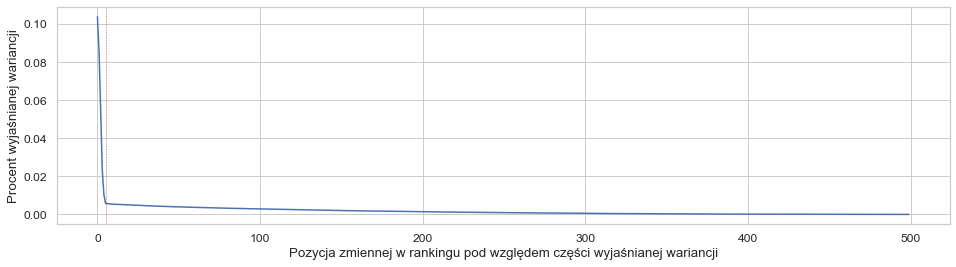

In [35]:
pca = PCA(random_state=0).fit(X_train)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

sns.lineplot(x=range(500), y=pca.explained_variance_ratio_)
plt.axvline(x=5, lw=0.5, c="r", ls="--")
plt.ylabel("Procent wyjaśnianej wariancji")
plt.xlabel("Pozycja zmiennej w rankingu pod względem części wyjaśnianej wariancji")
# plt.title("Wartości explained_variance_ratio_ z transformatora PCA posortowane malejąco", fontsize=14)
plt.savefig("explained_variance_ratio_.png", dpi=300, bbox_inches="tight")
plt.show()

# wyraźny "łokieć" około 5. zmiennej

#### regresja LASSO

In [22]:
lr_pca =  GridSearchCV(
    estimator=Pipeline(
        [
            ('pca', PCA(n_components=5, random_state=0)), 
            ('lr', LogisticRegression(penalty="l1", solver="liblinear", max_iter=100, random_state=0)),
        ]
    ),
    param_grid={
        "lr__C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
    },
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train, y=y_train)

lr_pca.best_score_

0.612

#### las losowy

In [28]:
rf_pca = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('pca', PCA(n_components=5, random_state=0)), 
            ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
        ]
    ),
    param_distributions={
        'rf__max_depth': [2, 6, 10, 16, 20],
        'rf__min_samples_split': [2, 4, 6, 10, 15, 20],
        'rf__min_samples_leaf': [2, 5, 10, 15, 20],
        'rf__max_features': [2, 4, 6, 10, "auto"],
        'rf__max_leaf_nodes': [25, 50, 75, 100],
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train, y=y_train)

rf_pca.best_score_

0.849

#### xgboost

In [24]:
xgb_pca = RandomizedSearchCV(
    estimator=Pipeline(
        [
            ('pca', PCA(n_components=5, random_state=0)), 
            ('xgb', XGBClassifier(objective='binary:logistic', n_estimators=100, eval_metric='logloss', random_state=0)),
        ]
    ),
    param_distributions={
        'xgb__max_depth': range(2, 10, 2),
        'xgb__gamma': np.arange(0, 1.0, 0.2),
        'xgb__min_child_weight': range(2, 20, 3),
        'xgb__subsample': np.arange(0.2, 1.0, 0.2),
        'xgb__colsample_bytree': np.arange(0.2, 1.0, 0.2)
    },
    n_iter=300,
    random_state=0,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1
).fit(X=X_train, y=y_train)

xgb_pca.best_score_

0.8514999999999999

### Wybór najlepszego modelu

In [50]:
# hiperparametry najlepszego modelu
rf_fi.best_params_

{'rf__min_samples_split': 6,
 'rf__min_samples_leaf': 2,
 'rf__max_leaf_nodes': 100,
 'rf__max_features': 6,
 'rf__max_depth': 16}

In [88]:
# poprawiamy hiperparametry najlepszego modelu, tak, aby zmiejszyć ryzyko zbyt mocnego dopasowania
final_model_cv = cross_validate(
    estimator=Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "rf",
                RandomForestClassifier(
                    n_estimators=1000,
                    random_state=0,
                    min_samples_split=8,
                    min_samples_leaf=4,
                    max_leaf_nodes=50,
                    max_features=6,
                    max_depth=12
                ),
            ),
        ]
    ),
    X=X_train.loc[:, important_features],
    y=y_train,
    scoring=balanced_accuracy,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1,
    return_estimator=True
)

final_model_cv["test_score"]

array([0.856, 0.87 , 0.866, 0.858])

In [89]:
# najlepszy model z cross-walidacji
final_model = final_model_cv["estimator"][2]

In [112]:
# zapisanie wyników
pd.Series(
    final_model.predict_proba(X_test.loc[:, important_features])[:, 1],
    name="313555"
).to_csv("../313555_artifical_model_prediction.txt", index=False)

## Model przygotowany za pomocą autoMLowej biblioteki `flaml`

In [5]:
from flaml import AutoML
from flaml.automl.data import get_output_from_log

In [7]:
def balanced_accuracy_automl(
    X_val, y_val, estimator, labels,
    X_train, y_train, weight_val=None, weight_train=None,
    *args,
):
    y_pred = estimator.predict(X_val)
    metric_value = _balanced_accuracy(y_val, y_pred)
    return 1 - metric_value, {"balanced_accuracy": metric_value}

In [ ]:
# drobne oszustwo - skalujemy dane
# bibliteka flaml tego nie czyni, przez co niektóre modele (np. regresja) nie zbiegają
scaler = StandardScaler().fit(X_train)

automl = AutoML()
automl.fit(
    scaler.transform(X_train), 
    y_train, 
    task="classification",
    metric=balanced_accuracy_automl,
    max_iter=500,
    log_file_name="automl.log",
    ensemble=True,
    eval_method="cv",
)

In [14]:
# najlepszy estymator
automl.best_estimator

'xgb_limitdepth'

In [23]:
# wyniki + hiperparametry
automl.best_result

{'pred_time': 0.0,
 'wall_clock_time': 2768.0770699977875,
 'metric_for_logging': {'balanced_accuracy': 0.43100000000000005},
 'val_loss': 0.5690000000000001,
 'training_iteration': 1,
 'config': {'n_estimators': 140,
  'max_depth': 8,
  'min_child_weight': 0.0017016439004551706,
  'learning_rate': 0.04110805315863727,
  'subsample': 1.0,
  'colsample_bylevel': 0.41500805283017983,
  'colsample_bytree': 0.8733398060540724,
  'reg_alpha': 0.008312402556375073,
  'reg_lambda': 0.0010060633605285527},
 'config/n_estimators': 140,
 'config/max_depth': 8,
 'config/min_child_weight': 0.0017016439004551706,
 'config/learning_rate': 0.04110805315863727,
 'config/subsample': 1.0,
 'config/colsample_bylevel': 0.41500805283017983,
 'config/colsample_bytree': 0.8733398060540724,
 'config/reg_alpha': 0.008312402556375073,
 'config/reg_lambda': 0.0010060633605285527,
 'experiment_tag': 'exp',
 'time_total_s': 27.8836567401886}

In [24]:
# testowane modele
automl.best_config_per_estimator.keys()

dict_keys(['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1'])

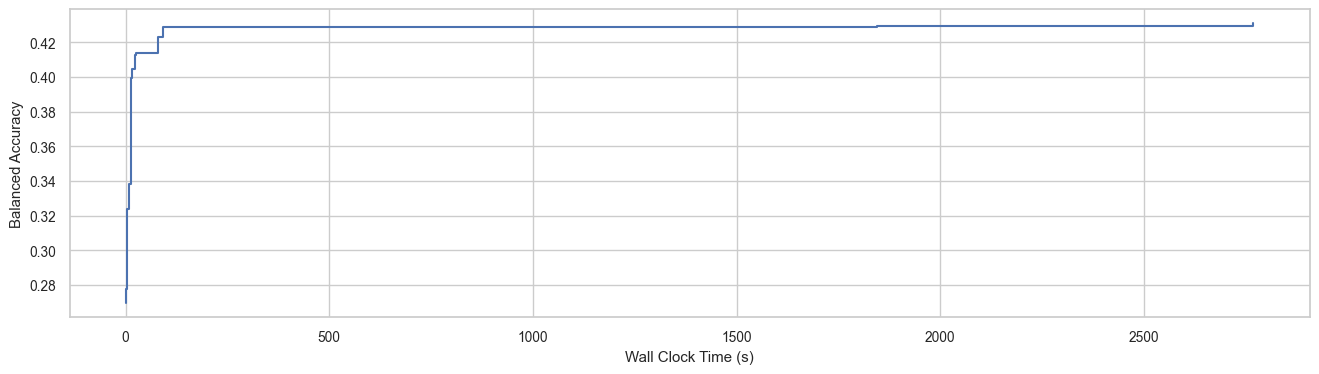

In [19]:
# learing curve
time_history, best_valid_loss_history, _, _, _ = get_output_from_log(filename="automl.log", time_budget=5000)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

# plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Balanced Accuracy")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.savefig("learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()

In [33]:
# zapisanie wyników
pd.Series(
    automl.model.predict_proba(scaler.transform(X_test))[:, 1],
    name="313555"
).to_csv("../313555_artifical_automl_prediction.txt", index=False)